In [11]:
# -*- coding: utf-8 -*-
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from pymongo import MongoClient
import yaml
import ssl

red_color_schema = "#cc1228"
green_color_schema = "#3c8c30"

In [12]:
def yaml_loader(config_path):
    with open(config_path) as f:
        return yaml.load(f)
    
config=yaml_loader("../server/config.yaml")

In [3]:
mongo_uri = config.get("mongo_uri").format(config.get("mongo_username"), config.get("mongo_password"))
db = MongoClient(mongo_uri,ssl=True,ssl_cert_reqs=ssl.CERT_NONE)
coll = db.ethereum.orders
# GET max and min prices.
result = coll.aggregate([{"$group": {"_id": None, "maxPrice": {"$max": "$price"}, "minPrice": {"$min": "$price"}
                                     }}])
data = result.next()
print(data)
max_price = int(data["maxPrice"])
min_price = int(data["minPrice"])

# print(y)

result = coll.find({})
datas = []
for data in result:
    datas.append(data)

{'_id': None, 'maxPrice': 227.32, 'minPrice': 201}


ETH Whales orders:


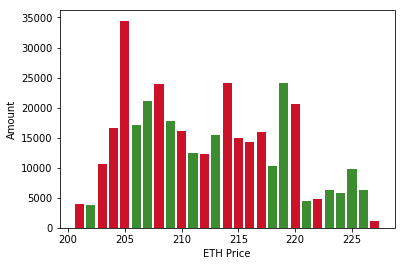

In [4]:
x = np.linspace(min_price,max_price,(max_price-min_price+1))
# print(x)

y = np.zeros((max_price-min_price+1))
y2 = np.zeros((max_price-min_price+1))


for data in datas:
        y[int(data["price"])-min_price]+=abs(data["amount"])
        y2[int(data["price"])-min_price]+=data["amount"]
# print(y)
# print(y2)
# print(x.shape)
for i in range(0,x.shape[0]):
    if y2[i]<0:
        y2[i]=y[i]
        y[i] = 0
    else:
        y2[i]=0
# print(y)
# print(y2)
print("ETH Whales orders:")
plt.xlabel('ETH Price')
plt.ylabel('Amount')

plt.bar(x, y, color=green_color_schema)
plt.bar(x,y2,color=red_color_schema)
plt.show()

ETH Whales orders larger than 300:


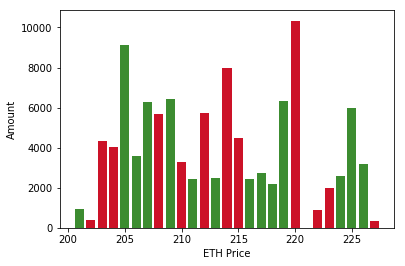

In [5]:
# Set a threshold for small orders.

y = np.zeros((max_price-min_price+1))
y2 = np.zeros((max_price-min_price+1))
threshold=300

for data in datas:
    if abs(data["amount"])>=threshold:
        y[int(data["price"])-min_price]+=abs(data["amount"])
        y2[int(data["price"])-min_price]+=data["amount"]

for i in range(0,x.shape[0]):
    if y2[i]<0:
        y2[i]=y[i]
        y[i] = 0
    else:
        y2[i]=0
# print(y)
# print(y2)
print("ETH Whales orders larger than 300:")


plt.xlabel('ETH Price')
plt.ylabel('Amount')

plt.bar(x, y, color=green_color_schema)
plt.bar(x,y2,color=red_color_schema)
plt.show()

In [17]:
def draw_volume(collection, start_time, end_time, filter_func=None, *, title=""):
    result = coll.find({"time": {"$lt": end_time,"$gt":start_time}})
    
    result = list(result)
    
    max_price = int(max(result, key=lambda x: x["price"])["price"])
    min_price = int(min(result, key=lambda x: x["price"])["price"])
    
    x = np.linspace(min_price,max_price,(max_price-min_price+1))

    y = np.zeros((max_price-min_price+1))
    y2 = np.zeros((max_price-min_price+1))


    for data in result:
        if not filter_func or filter_func(data):
            y[int(data["price"])-min_price]+=abs(data["amount"])
            y2[int(data["price"])-min_price]+=data["amount"]
        
    for i in range(0,x.shape[0]):
        if y2[i]<0:
            y2[i]=y[i]
            y[i] = 0
        else:
            y2[i]=0
            
    plt.title(title)
    plt.xlabel('ETH Price')
    plt.ylabel('Amount')

    plt.bar(x, y, color=green_color_schema)
    plt.bar(x,y2,color=red_color_schema)
    plt.show()

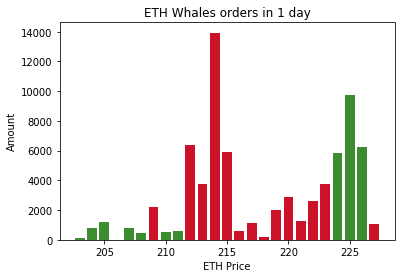

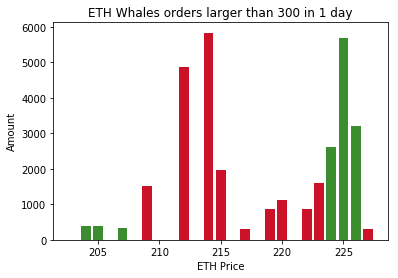

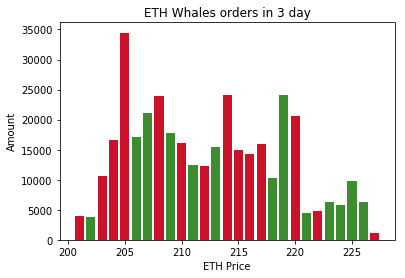

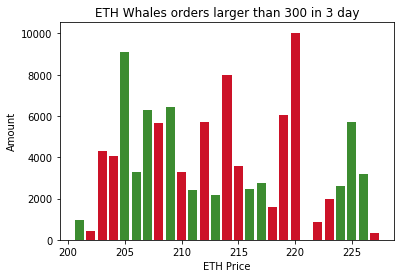

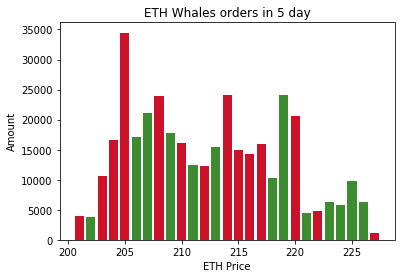

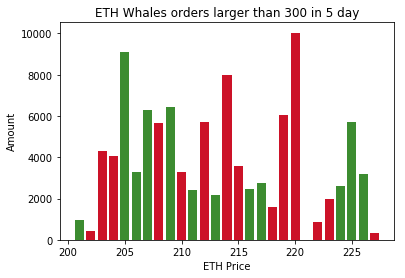

In [20]:
import time 

mongo_uri = config.get("mongo_uri").format(config.get("mongo_username"), config.get("mongo_password"))
db = MongoClient(mongo_uri,ssl=True,ssl_cert_reqs=ssl.CERT_NONE)
coll = db.ethereum.orders

draw_volume(coll, int((time.time()-24*3600)*1000), int(time.time()*1000), title="ETH Whales orders in 1 day")
draw_volume(coll, int((time.time()-24*3600)*1000), int(time.time()*1000), lambda x: abs(x["amount"]) > 300, title="ETH Whales orders larger than 300 in 1 day")

draw_volume(coll, int((time.time()-3*24*3600)*1000), int(time.time()*1000), title="ETH Whales orders in 3 day")
draw_volume(coll, int((time.time()-3*24*3600)*1000), int(time.time()*1000), lambda x: abs(x["amount"]) > 300, title="ETH Whales orders larger than 300 in 3 day")

draw_volume(coll, int((time.time()-5*24*3600)*1000), int(time.time()*1000), title="ETH Whales orders in 5 day")
draw_volume(coll, int((time.time()-5*24*3600)*1000), int(time.time()*1000), lambda x: abs(x["amount"]) > 300, title="ETH Whales orders larger than 300 in 5 day")

In [ ]:
mongo_uri = config.get("mongo_uri").format(config.get("mongo_username"), config.get("mongo_password"))
db = MongoClient(mongo_uri,ssl=True,ssl_cert_reqs=ssl.CERT_NONE)
coll = db.ethereum.orders
# GET max and min prices.
result = coll.aggregate([{"$group": {"_id": "$price", "orders": {"$push" : "$amount"}
                                     }}])
lists = []
for data in result:
    data['total'] = sum([abs(i) for i in data['orders']])
    data['direction'] = sum([i for i in data['orders']])

    lists.append(data)

datas=sorted(lists,key=lambda lists: lists['total'],reverse = True)
x = np.array([i['_id'] for i in datas[:30]])
y = np.array([i['total'] for i in datas[:30]])
plt.title("ETH amount base on price (Accurate)")
plt.xlabel('ETH Price')
plt.ylabel('Amount')

plt.bar(x, y, color=green_color_schema)
plt.show()


In [4]:
import datetime
import random
import matplotlib.dates as mdates


In [19]:
def draw_time_series_orders(collection, start_time, end_time,period, filter_func=None, *, title=""):
    def convert_to_datetime64(timestamp):
        dt= datetime.datetime.utcfromtimestamp(timestamp/1000)
        return np.datetime64(dt)
        
    result = coll.find({"time": {"$lt": end_time,"$gt":start_time}})
    
    result = list(result)
    
    start=convert_to_datetime64(start_time)
    end = convert_to_datetime64(end_time)
#     print(start)
#     print(end)
    x = np.arange(start, end, dtype='datetime64[{}m]'.format(period))
#     print(x)
    y = np.zeros(x.shape[0])
    y2 = np.zeros(x.shape[0])

    position = 0
    for data in result:
        if position<x.shape[0]-1 and convert_to_datetime64(data["time"])> x[position+1]:
            position+=1
        if not filter_func or filter_func(data):
            if data["amount"]>=0:
                y[position]+=data["amount"]
            else:
                y2[position]+=data["amount"]
#     print(y)
#     for i in range(0,x.shape[0]):
#         if y2[i]<0:
#             y2[i]=y[i]
#             y[i] = 0
#         else:
#             y2[i]=0
            
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Amount')

    plt.bar(x, y, color=green_color_schema,width=0.05)
    plt.bar(x, y2, color=red_color_schema,width=0.05)

    plt.gcf().autofmt_xdate()
    myFmt = mdates.DateFormatter('%m-%d %H:%M')
    plt.gca().xaxis.set_major_formatter(myFmt)

#     plt.bar(x,y2,color=red_color_schema)
    plt.show()

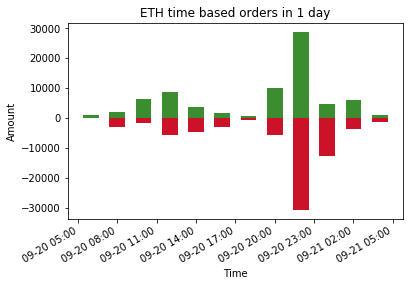

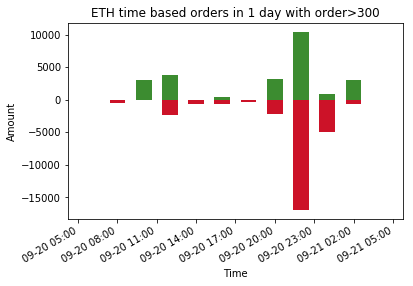

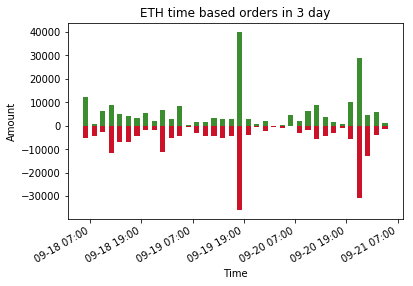

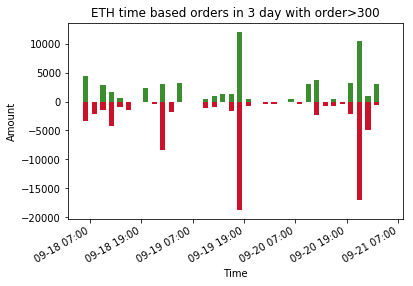

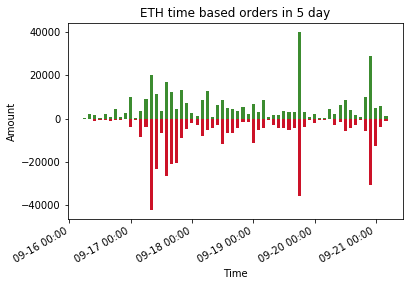

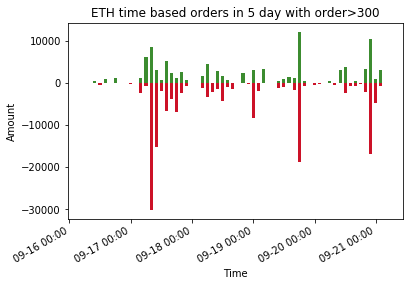

In [20]:
import time
mongo_uri = config.get("mongo_uri").format(config.get("mongo_username"), config.get("mongo_password"))
db = MongoClient(mongo_uri,ssl=True,ssl_cert_reqs=ssl.CERT_NONE)
coll = db.ethereum.orders

draw_time_series_orders(coll, int((time.time()-24*3600)*1000), 
                        int(time.time()*1000),120, title="ETH time based orders in 1 day")
draw_time_series_orders(coll, int((time.time()-24*3600)*1000), 
                        int(time.time()*1000),120, lambda x: abs(x["amount"]) > 300, title="ETH time based orders in 1 day with order>300")
draw_time_series_orders(coll, int((time.time()-72*3600)*1000), 
                        int(time.time()*1000),120, title="ETH time based orders in 3 day")
draw_time_series_orders(coll, int((time.time()-72*3600)*1000), 
                        int(time.time()*1000),120, lambda x: abs(x["amount"]) > 300, title="ETH time based orders in 3 day with order>300")
draw_time_series_orders(coll, int((time.time()-120*3600)*1000), 
                        int(time.time()*1000),120, title="ETH time based orders in 5 day")
draw_time_series_orders(coll, int((time.time()-120*3600)*1000), 
                        int(time.time()*1000),120, lambda x: abs(x["amount"]) > 300, title="ETH time based orders in 5 day with order>300")
